   trial  iteration recommender              dataset ml-rec  \
0      0          0        meta             kr-vs-kp    SVC   
1      0          1        meta  analcatdata_lawsuit    SVC   
2      0          2        meta                monk2    SVC   
3      0          3        meta                led24    SVC   
4      0          4        meta            promoters    SVC   

                                               p-rec  score-rec  bal_accuracy  
0  OrderedDict([('C', 0.01), ('coef0', 0.0), ('de...   0.451469      0.503274  
1  OrderedDict([('C', 0.01), ('coef0', 0.0), ('de...   0.502968      0.500000  
2  OrderedDict([('C', 0.01), ('coef0', 0.0), ('de...   0.500017      0.500000  
3  OrderedDict([('C', 0.01), ('coef0', 0.0), ('de...   0.500000      0.500000  
4  OrderedDict([('C', 0.01), ('coef0', 0.0), ('de...   0.500001      0.707547  
Index(['trial', 'iteration', 'recommender', 'dataset', 'ml-rec', 'p-rec',
       'score-rec', 'bal_accuracy'],
      dtype='object')


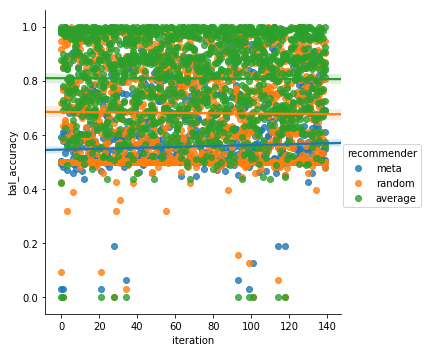

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

experiment = '../experiment_meta-random-average_1recs_10trials_10init.csv'
df_exp = pd.read_csv(experiment,sep='\t')
print(df_exp[:5])
print(df_exp.columns)
plt.figure(figsize=(20,10))
sb.lmplot(data=df_exp, x='iteration',y='bal_accuracy',hue='recommender')
#sb.tsplot(data=df, time="iteration", condition="recommender", value="bal_accuracy", 
#          err_style="ci_bars", estimator=np.median)
# sb.boxplot(data=df,x='iteration',y='bal_accuracy',hue='recommender')
#plt.ylim([0.5,1])
plt.savefig(experiment[:-4]+'accuracy_comparison.pdf')

In [20]:
# load results
pmlb_file = 'sklearn-benchmark5-data-mock_experiment.tsv.gz'                    
# load pmlb data                                                                                
print('load pmlb data')                                                                         
pmlb_data = pd.read_csv(pmlb_file,                                                              
                        compression='gzip', sep='\t').fillna('')
pmlb_data.info()
df = pmlb_data.groupby('dataset')['bal_accuracy'].max()

pmlb_data = pmlb_data.merge(df.to_frame(name='max_bal_accuracy'), left_on='dataset',right_index=True) 
print(pmlb_data.head())

load pmlb data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35850 entries, 0 to 35849
Data columns (total 6 columns):
dataset         35850 non-null object
algorithm       35850 non-null object
parameters      35850 non-null object
accuracy        35850 non-null float64
macrof1         35850 non-null float64
bal_accuracy    35850 non-null float64
dtypes: float64(3), object(3)
memory usage: 1.6+ MB
                                             dataset               algorithm  \
0  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   
1  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   
2  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   
3  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   
4  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   

                                          parameters  accuracy   macrof1  \
0  OrderedDict([('criterion', 'entrop

In [18]:
rec_delta = pd.DataFrame(columns=['dataset','delta'])
frames = []
for d in df_exp['dataset'].unique():
    delta = pmlb_data.loc[0,pmlb_data['dataset']==d]['max_bal_accuracy'] - 
            df_exp.loc[df_exp['dataset']==d]['bal_accuracy']
    
print(rec_delta)

TypeError: unsupported operand type(s) for -: 'SeriesGroupBy' and 'SeriesGroupBy'

algs: ['SVC', 'GradientBoostingClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier']
ave_count_mat (5, 140)


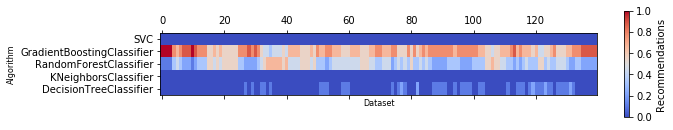

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# generate figure of heatmap showing counts of which ML methods are recommended over time
experiment = '../experiment_meta-random-average_1recs_10trials_10init.csv'
# experiment = '../experiment_random-average_100recs_500trials_1init.csv'
accumulate = False
recommender = 'average'
df = pd.read_csv(experiment,sep='\t')
n_trials = df['trial'].max()
ave_count_mat = np.zeros((len(df['ml-rec'].unique()),len(df['iteration'].unique())))                     
rand_count_mat = np.zeros((len(df['ml-rec'].unique()),len(df['iteration'].unique())))
algs = list(df['ml-rec'].unique())
iterations = df['iteration'].unique()
print('algs:',algs)
print('ave_count_mat',ave_count_mat.shape)

dfa = df.loc[df['recommender']==recommender,:]

dfa.groupby('iteration').count() #.groupby('ml-rec').count()

for index,row in dfa.iterrows():
    ave_count_mat[algs.index(row['ml-rec']),row['iteration']] += 1/n_trials
# cumulative sum
if accumulate:
    for i,a in enumerate(ave_count_mat): 
        ave_count_mat[i] = np.cumsum(a)
#print('ave_count_mat:',ave_count_mat)
        
h = plt.figure(figsize=(10, 15))
ax = h.gca()
tmp = ax.matshow(ave_count_mat,cmap=plt.cm.coolwarm)
# sb.heatmap(ave_count_mat)#,
           #cmap=sb.cubehelix_palette(500, light=0.95, dark=0.15),
#            square=False, annot=True, vmin=0., vmax=1.0,
#            xticklabels=iterations, yticklabels=algs, cbar=False)
cbar=plt.colorbar(tmp,ax=ax,orientation='vertical',shrink=0.1)
cbar.set_label('Recommendations')
ax.set_yticks(np.arange(len(algs)))
ax.set_yticklabels(algs)
ax.set_xlabel('Dataset', fontsize=8)
ax.set_ylabel('Algorithm', fontsize=8)
#plt.title('ML Recommendations over many datasets', fontsize=18)
ax.set_aspect(4)
h.tight_layout()
if accumulate:
    h.savefig(experiment[:-4]+'_'+recommender+'_heatmap_cumulative.pdf', bbox_inches='tight')
else:
    h.savefig(experiment[:-4]+'_'+recommender+'_heatmap.pdf', bbox_inches='tight')
    